# 0.0. Imports

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import statsmodels.api as sm
from IPython.display import HTML
from yellowbrick.cluster import KElbowVisualizer

from sklearn import cluster
from sklearn import metrics

## 0.1. Helper Functions

In [126]:
def descriptive_statistics(num_attr):
    # Central Tendency: mean, median
    c1 = pd.DataFrame(num_attr.apply(np.mean))
    c2 = pd.DataFrame(num_attr.apply(np.median))

    # Dispension: min, max, range, std, skew, kurtosis
    d1 = pd.DataFrame(num_attr.apply(min))
    d2 = pd.DataFrame(num_attr.apply(max))
    d3 = pd.DataFrame(num_attr.apply(lambda x: x.max() - x.min()))
    d4 = pd.DataFrame(num_attr.apply(lambda x: x.std()))
    
    # Measures of Shape
    s1 = pd.DataFrame(num_attr.apply(lambda x: x.skew()))
    s2 = pd.DataFrame(num_attr.apply(lambda x: x.kurtosis()))

    # concat
    m = pd.concat([d1,d2,d3,c1,c2,d4,s1,s2], axis=1).reset_index()
    m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
    return m


def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'ggplot')
    plt.rcParams['figure.figsize'] = [24, 9]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    pd.set_option('display.float_format', lambda x: '%.2f' % x)
    
    sns.set()
    
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2. Load Dataset

In [26]:
df_raw = pd.read_csv( '../data/raw/Ecommerce.csv', encoding='latin1' )

# drop extra column
df_raw = df_raw.drop(columns=['Unnamed: 8'])

# 1.0. Data Description

In [27]:
df1 = df_raw.copy()

## 1.1. Rename Columns

**Attribute Description**


* **InvoiceNo** Invoice number (A 6-digit integral number uniquely assigned to each transaction)
* **StockCode** Product (item) code
* **Description** Product (item) name
* **Quantity** The quantities of each product (item) per transaction
* **InvoiceDate** The day when each transaction was generated
* **UnitPrice** Unit price (Product price per unit)
* **CustomerID** Customer number (Unique ID assigned to each customer)
* **Country** Country name (The name of the country where each customer resides)

In [28]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']
df1.columns = cols_new

## 1.2. Data Dimensions

In [30]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Columns/Features: {}'.format(df1.shape[1]))

Number of Rows: 541909
Number of Columns/Features: 8


## 1.3. Data Types

In [31]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4. Check NA

In [33]:
df1.isna().mean()

invoice_no      0.000000
stock_code      0.000000
description     0.002683
quantity        0.000000
invoice_date    0.000000
unit_price      0.000000
customer_id     0.249267
country         0.000000
dtype: float64

## 1.5. Replace NA 

In [34]:
df1 = df1.dropna(subset=['description', 'customer_id'])

print('Removed data: {}%'.format(round(1 - (df1.shape[0] / df_raw.shape[0]), 2) *100))

Removed data: 25.0%


## 1.6. Change Dtypes

In [35]:
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'])

df1['customer_id'] = df1['customer_id'].astype(int)

## 1.7. Descriptive Statistics

In [36]:
num_attr = df1.select_dtypes(include=['int64', 'float64'])
cat_attr = df1.select_dtypes(include=['object'])

### 1.7.1. Numerical Attributes



In [37]:
descriptive_statistics(num_attr)

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.0,80995.0,161990.0,12.061303,5.00,248.693370,0.182663,94317.563673
1,unit_price,0.0,38970.0,38970.0,3.460471,1.95,69.315162,452.219019,246924.542988
2,customer_id,12346.0,18287.0,5941.0,15287.690570,15152.00,1713.600303,0.029835,-1.179982


# 2.0. Feature Engeering

In [97]:
df2 = df1.copy()

## 2.1. Feature Creation

In [98]:
cols_drop = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date',
             'unit_price', 'country']

df_ref = df2.drop(columns=cols_drop).drop_duplicates(ignore_index=True)

In [99]:
# Monetary: gross_revenue = quantity * unit_price
df2['gross_revenue'] = df2['quantity'] * df2['unit_price']

df_monetary = df2.loc[:, ['gross_revenue', 'customer_id']].groupby('customer_id').mean().reset_index()

df_ref = pd.merge(df_ref, df_monetary, how='left', on='customer_id')
df_ref.isna().sum()

customer_id      0
gross_revenue    0
dtype: int64

In [100]:
# recency
df_recency = df2.loc[:, ['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency'] = (df_recency['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id', 'recency']]


df_ref = pd.merge(df_ref, df_recency, how='left', on='customer_id')
df_ref.isna().sum()

customer_id      0
gross_revenue    0
recency          0
dtype: int64

In [101]:
# frequency
df_frequency = df2.loc[: , ['invoice_no', 'customer_id']].groupby('customer_id').count().reset_index()
df_ref = pd.merge(df_ref, df_frequency, how='left', on='customer_id')

df_ref.isna().sum()

customer_id      0
gross_revenue    0
recency          0
invoice_no       0
dtype: int64

# 3.0. Data Filtering

In [102]:
df3 = df_ref.copy()

# 4.0. Exploratory Data Analysis

In [103]:
df4 = df3.copy()

# 5.0. Data Preparation

In [104]:
df5  = df4.copy()

## 5.1. Normality Test

/home/cid/.pyenv/versions/3.8.0/envs/clustering-high-value-customers-identification/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning:

marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.



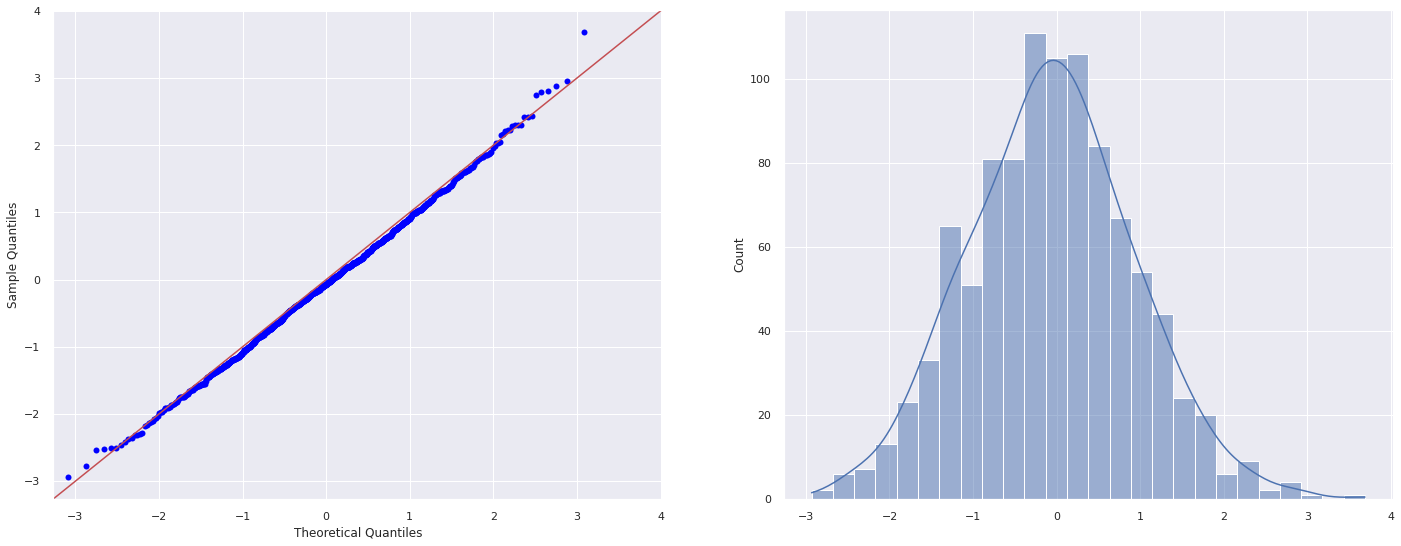

In [105]:
fig, ax = plt.subplots(1, 2)

data_points = np.random.normal(0, 1, 1000)    

sm.qqplot(data_points, line ='45', ax=ax[0])
sns.histplot(data_points, kde=True, ax=ax[1])

plt.show();

/home/cid/.pyenv/versions/3.8.0/envs/clustering-high-value-customers-identification/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning:

marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.



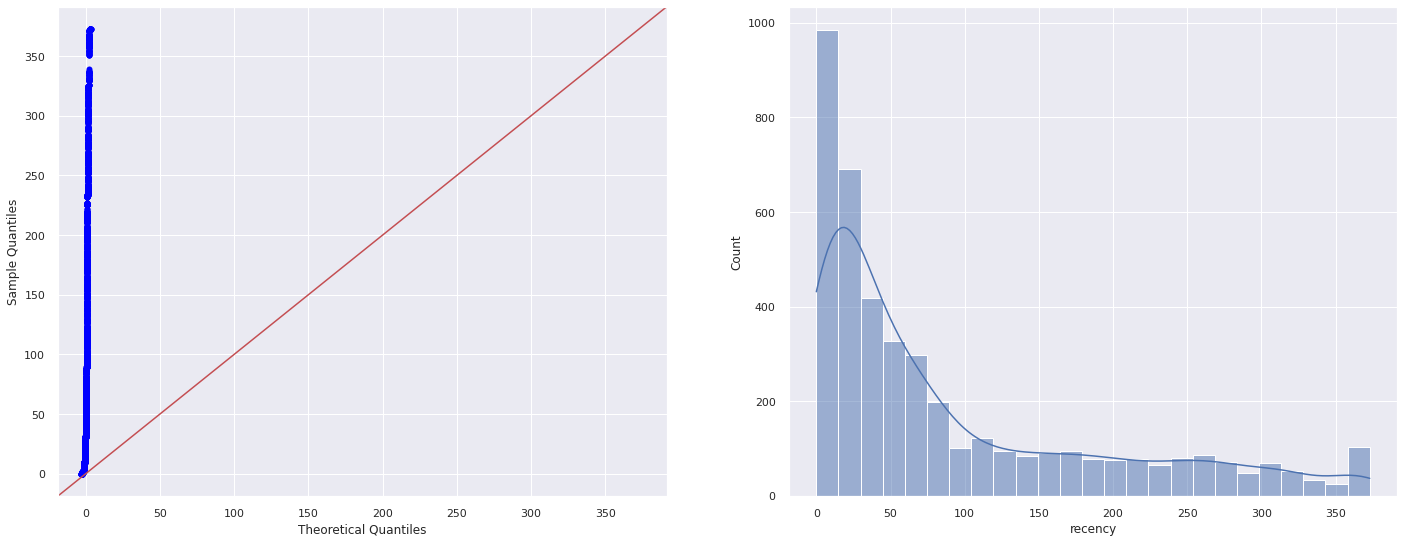

In [106]:
fig, ax = plt.subplots(1, 2)

sm.qqplot(df5['recency'], line ='45', ax=ax[0])
sns.histplot(df5['recency'], kde=True, ax=ax[1])

plt.show();

/home/cid/.pyenv/versions/3.8.0/envs/clustering-high-value-customers-identification/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning:

marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.



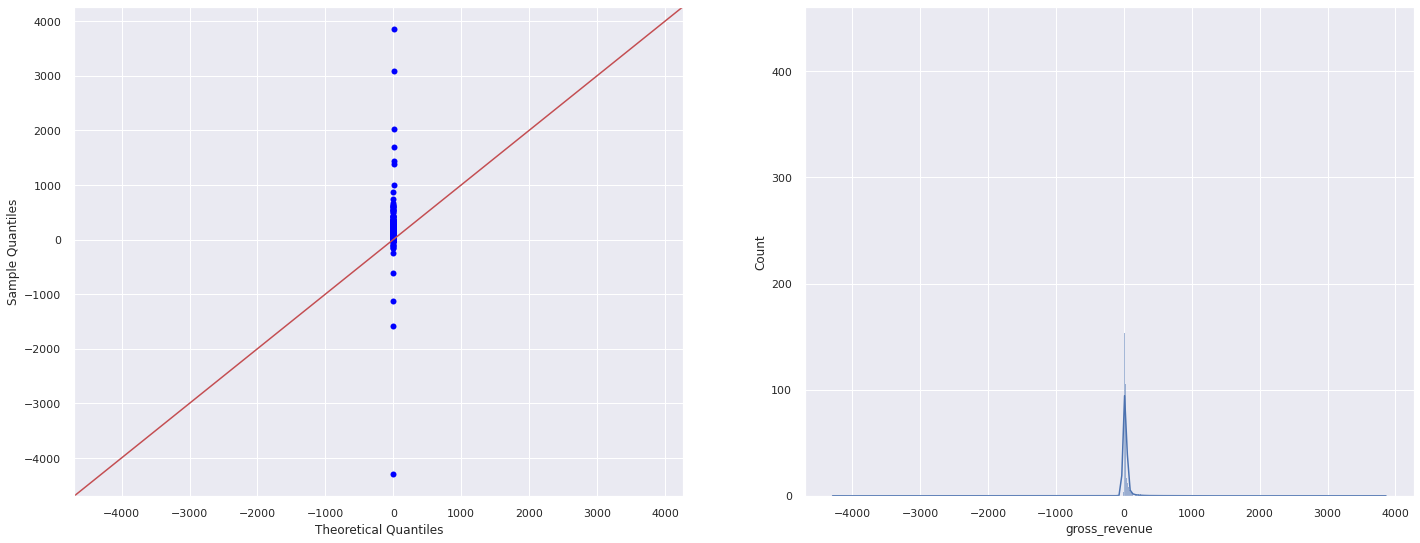

In [107]:
fig, ax = plt.subplots(1, 2)

sm.qqplot(df5['gross_revenue'], line ='45', ax=ax[0])
sns.histplot(df5['gross_revenue'], kde=True, ax=ax[1])

plt.show();

/home/cid/.pyenv/versions/3.8.0/envs/clustering-high-value-customers-identification/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning:

marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.



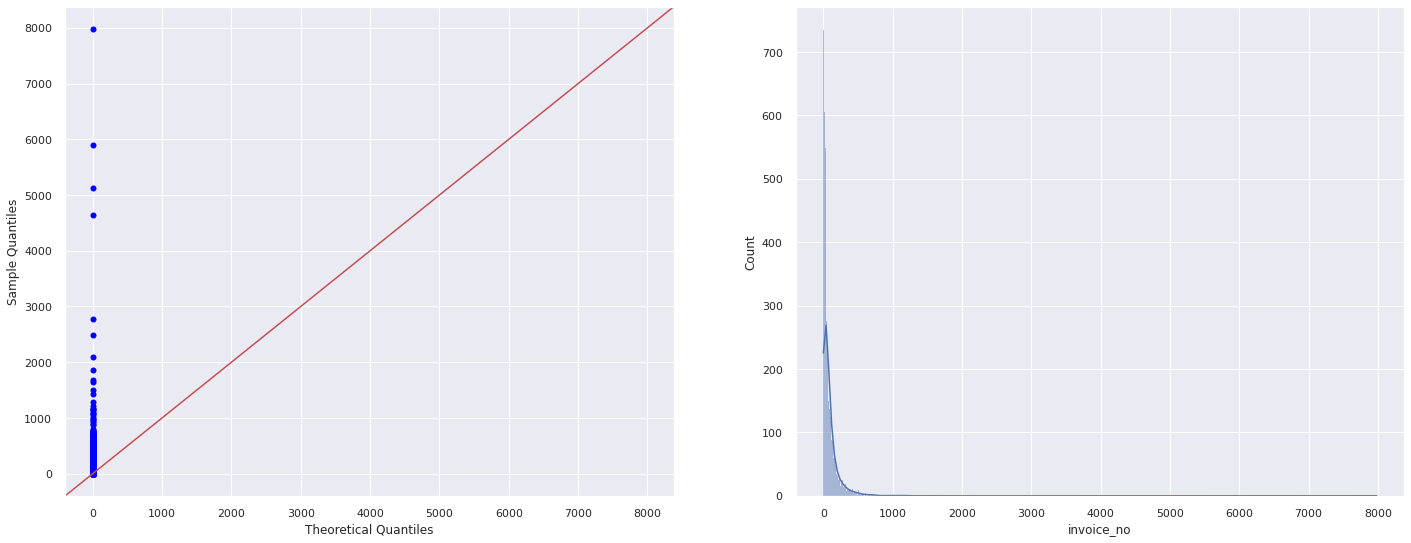

In [108]:
fig, ax = plt.subplots(1, 2)

sm.qqplot(df5['invoice_no'], line ='45', ax=ax[0])
sns.histplot(df5['invoice_no'], kde=True, ax=ax[1])

plt.show();

# 6.0. Feature Selection

In [109]:
df6 = df5.copy()

# 7.0. Hyperparameter Fine-Tunning

In [110]:
X = df6.drop(columns=['customer_id'])
X.head()

,gross_revenue,recency,invoice_no
0,16.950737,302,312
1,15.709694,31,196
2,28.634821,2,251
3,33.866071,95,28
4,105.850000,330,6


In [111]:
clusters = [2,3,4,5,6,7]

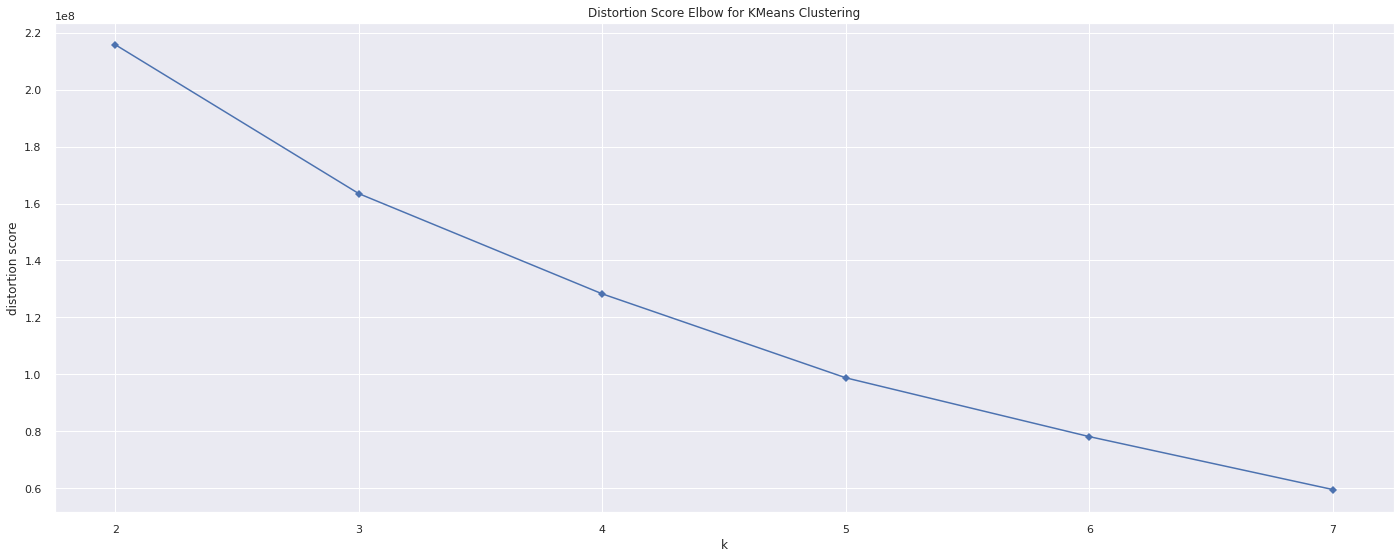

In [112]:
kmeans = KElbowVisualizer(cluster.KMeans(), k=clusters, timings=False, locate_elbow=False)
kmeans.fit(X)
kmeans.show();

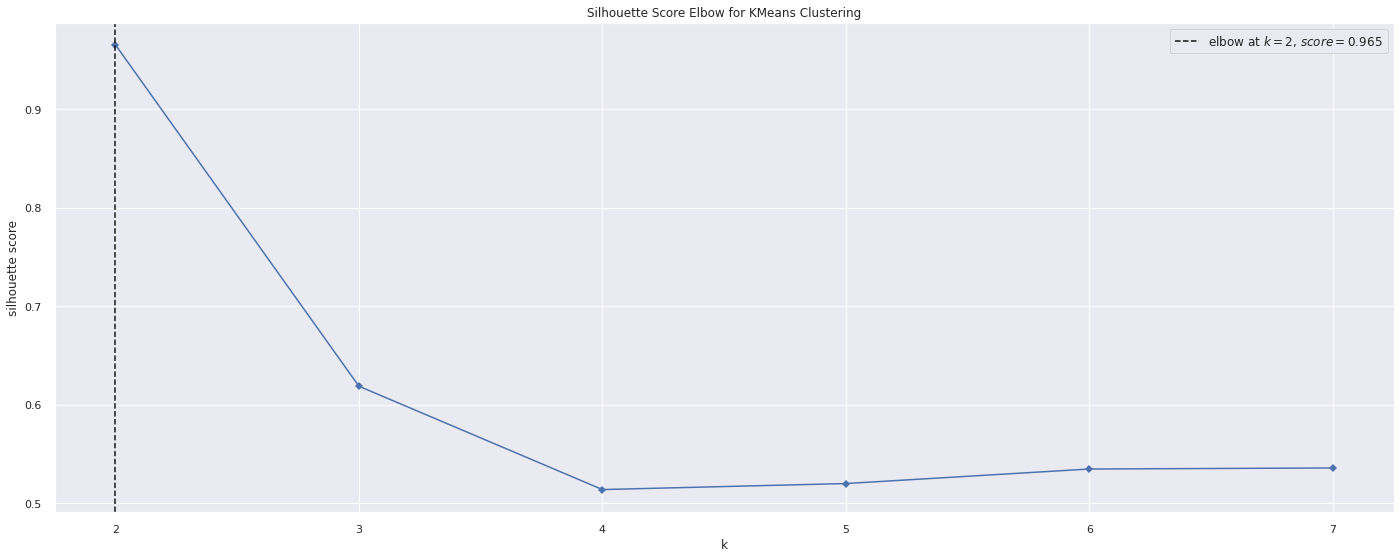

In [113]:
kmeans = KElbowVisualizer(cluster.KMeans(), k=clusters, metric='silhouette', timings=False, locate_elbow=True)
kmeans.fit(X)
kmeans.show();

# 8.0. Model Training

## 8.1. K-Means

In [121]:
# model definition
k = 5
kmeans = cluster.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300)

# model training
kmeans.fit(X)

# clustering
labels = kmeans.labels_

## 8.2. Cluster Validation

In [127]:
print('WSS value: {}'.format(kmeans.inertia_))
print('SS value: {}'.format(metrics.silhouette_score(X, labels, metric='euclidean')))

WSS value: 98661304.43315282
SS value: 0.5232678004491962


# 9.0. Cluster Analysis

In [132]:
df9 = df6.copy()
df9['cluster'] = labels
df9.head()

,customer_id,gross_revenue,recency,invoice_no,cluster
0,17850,16.95,302,312,0
1,13047,15.71,31,196,2
2,12583,28.63,2,251,2
3,13748,33.87,95,28,2
4,15100,105.85,330,6,0


## 9.1.Visualizantion Inspection

In [117]:
fig = px.scatter_3d(df9, x='recency', y='invoice_no', z='invoice_no', color='cluster')
fig.show()

## 9.2. Cluster Profile

In [124]:
df9.head()

,customer_id,gross_revenue,recency,invoice_no,cluster
0,17850,16.950737,302,312,0
1,13047,15.709694,31,196,2
2,12583,28.634821,2,251,2
3,13748,33.866071,95,28,2
4,15100,105.850000,330,6,0


In [139]:
df_cluster = df9[['customer_id', 'cluster']].groupby( 'cluster' ).count().reset_index()
df_cluster['perc_customer'] = 100*( df_cluster['customer_id'] / df_cluster['customer_id'].sum() )

# Avg Gross revenue
df_avg_gross_revenue = df9[['gross_revenue', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_gross_revenue, how='inner', on='cluster' )

# Avg recency days
df_avg_recency_days = df9[['recency', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_recency_days, how='inner', on='cluster' )

# Avg invoice_no
df_invoice_no = df9[['invoice_no', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_invoice_no, how='inner', on='cluster' )

df_cluster = df_cluster.sort_values('gross_revenue', ascending=False)
df_cluster

,cluster,customer_id,perc_customer,gross_revenue,recency,invoice_no
1,1,6,0.14,2248.35,89.50,5.17
2,2,3036,69.44,27.58,41.88,75.11
4,4,235,5.38,22.31,14.06,537.82
0,0,1091,24.95,21.60,246.93,26.32
3,3,4,0.09,11.23,1.50,5914.00


# 10.0. Deploy to Production